In [25]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume
from natsume.common import get_MMR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.constants import M_earth

In [57]:
# Import CSV for nominal mass
nominals = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\1st_order\lithwick_nominal.csv")
nominals.head()

,Kepler_ID,MMR,P_in,P_out,V_in,V_out,m_nom_in,m_nom_in_err,m_nom_out,m_nom_out_err,mstar
0,18c/d,2:1,7.642,14.860,0.0037,0.00280,20.20,1.9,17.4,1.2,0.972
1,24b/c,3:2,8.146,12.330,0.0280,0.02600,28.40,5.9,50.4,7.9,1.100
2,25b/c,2:1,6.239,12.720,0.0026,0.00072,7.13,2.5,13.1,2.6,1.100
3,23b/c,3:2,7.107,10.740,0.0310,0.01300,14.70,3.8,55.0,22.0,1.210
4,28b/c,3:2,5.912,8.986,0.0082,0.00860,14.80,4.2,22.9,5.7,0.890


In [58]:
# Extract columns from nominals
mmr = nominals['MMR']
P_in = nominals['P_in']
P_out = nominals['P_out']
V_in = nominals['V_in']
V_out = nominals['V_out']
Mstar = nominals['mstar']
z = natsume.get_ComplexEccentricities() # Zero eccentricity

# Extract j and N
j, N = np.array([]), np.array([])
for str in mmr:
    ji, Ni = get_MMR(str)
    j = np.append(j, ji)
    N = np.append(N, Ni)

# Calculate super-period
PTTV = 1/np.abs(j/P_out - (j-N)/P_in)

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
for i in range(len(mmr)):
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z, inner_period=P_in[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z, outer_period=P_out[i])

    m_in = (mu_in * Mstar[i]*u.M_sun).to(u.M_earth).value
    m_out = (mu_out * Mstar[i]*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

compare = nominals.copy()
compare['m_calc_in'] = mcalc_in
compare['m_calc_out'] = mcalc_out
compare.head()

,Kepler_ID,MMR,P_in,P_out,V_in,V_out,m_nom_in,m_nom_in_err,m_nom_out,m_nom_out_err,mstar,m_calc_in,m_calc_out
0,18c/d,2:1,7.642,14.860,0.0037,0.00280,20.20,1.9,17.4,1.2,0.972,21.836565,17.278926
1,24b/c,3:2,8.146,12.330,0.0280,0.02600,28.40,5.9,50.4,7.9,1.100,27.201667,47.792179
2,25b/c,2:1,6.239,12.720,0.0026,0.00072,7.13,2.5,13.1,2.6,1.100,6.467586,12.844197
3,23b/c,3:2,7.107,10.740,0.0310,0.01300,14.70,3.8,55.0,22.0,1.210,14.045894,54.498433
4,28b/c,3:2,5.912,8.986,0.0082,0.00860,14.80,4.2,22.9,5.7,0.890,14.777013,23.146310


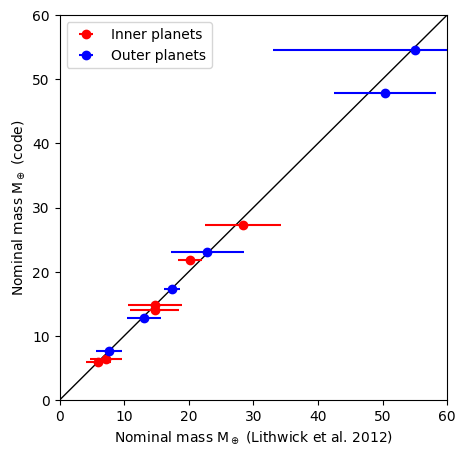

In [59]:
# Graph compare Nominal masses
plt.figure(figsize=(5, 5))
plt.errorbar(x=compare['m_nom_in'], y=compare['m_calc_in'], xerr=compare['m_nom_in_err'],
             fmt='o', linestyle='none', color='red', label='Inner planets')
plt.errorbar(x=compare['m_nom_out'], y=compare['m_calc_out'], xerr=compare['m_nom_out_err'],
             fmt='o', linestyle='none', color='blue', label='Outer planets')

maxval = 60
plt.plot([0, maxval], [0, maxval], color='black', zorder=0, lw=1)

plt.xlim(0, maxval)
plt.xlabel('Nominal mass M$_\oplus$ (Lithwick et al. 2012)')

plt.ylim(0, maxval)
plt.ylabel('Nominal mass M$_\oplus$ (code)')

plt.legend()

plt.show()

In [60]:
# Import CSV for Lithwick elses
figs = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\1st_order\lithwick_figs.csv")
figs.head()

,System,MMR,P_in,P_out,z_free_in,z_free_out,m_sol_in,m_sol_in_err,m_sol_out,m_sol_out_err,V_in,V_out,PTTV_in,PTTV_out
0,Figure 2-1,2:1,7.642,14.86,0,0.00,17.30,1.700,15.800,1.300,0.003381,0.002177,266.714462,267.131306
1,Figure 2-2,2:1,7.642,14.86,0.03j,0.00,17.30,1.700,15.800,1.300,0.007950,0.010380,267.077207,267.094945
2,Figure 3,2:1,7.642,14.86,0.05,0.05,3.46,0.629,5.846,0.481,0.002306,0.001903,268.751842,268.829586


In [61]:
# Extract columns from figs
mmr = figs['MMR']
P_in = figs['P_in']
P_out = figs['P_out']
PTTV_in = figs['PTTV_in']
PTTV_out = figs['PTTV_out']

V_in = figs['V_in']
V_out = figs['V_out']
Mstar = 0.972

e1 = figs['z_free_in'].apply(complex).apply(abs)
w1 = figs['z_free_in'].apply(complex).apply(np.angle).apply(np.rad2deg)
e2 = figs['z_free_out'].apply(complex).apply(abs)
w2 = figs['z_free_out'].apply(complex).apply(np.angle).apply(np.rad2deg)
z = [natsume.get_ComplexEccentricities(e1[i], w1[i], e2[i], w2[i]) for i in range(len(e1))]

mu_in_sol = (figs['m_sol_in'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (figs['m_sol_out'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])
for i in range(len(mmr)):
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare2 = figs.copy()
compare2['m_calc_in'] = mcalc_in
compare2['m_calc_out'] = mcalc_out
compare2['m_bad_in'] = mbad_in
compare2['m_bad_out'] = mbad_out
compare2.head()

,System,MMR,P_in,P_out,z_free_in,z_free_out,m_sol_in,m_sol_in_err,m_sol_out,m_sol_out_err,V_in,V_out,PTTV_in,PTTV_out,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,Figure 2-1,2:1,7.642,14.86,0,0.00,17.30,1.700,15.800,1.300,0.003381,0.002177,266.714462,267.131306,17.014444,15.850776,22.099238,18.658834
1,Figure 2-2,2:1,7.642,14.86,0.03j,0.00,17.30,1.700,15.800,1.300,0.007950,0.010380,267.077207,267.094945,18.930075,19.571925,21.135596,23.992119
2,Figure 3,2:1,7.642,14.86,0.05,0.05,3.46,0.629,5.846,0.481,0.002306,0.001903,268.751842,268.829586,4.507221,16.255198,2.961500,4.643375


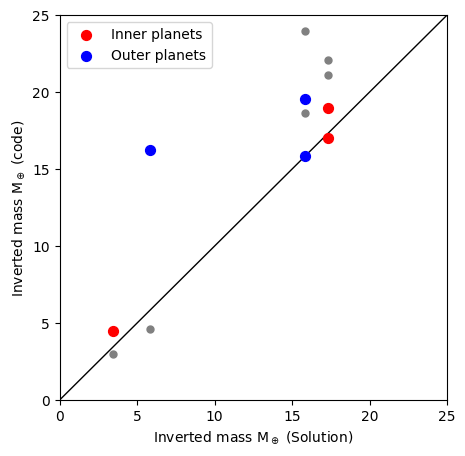

In [62]:
# Graph compare N-body outputs
plt.figure(figsize=(5, 5))
s = 50
plt.scatter(x=compare2['m_sol_in'], y=compare2['m_calc_in'],
             s=s, color='red', label='Inner planets')
plt.scatter(x=compare2['m_sol_out'], y=compare2['m_calc_out'],
             s=s, color='blue', label='Outer planets')

plt.scatter(x=compare2['m_sol_in'], y=compare2['m_bad_in'],
             s=s/2, color='grey')
plt.scatter(x=compare2['m_sol_out'], y=compare2['m_bad_out'],
             s=s/2, color='grey')

maxval = 25
plt.plot([0, maxval], [0, maxval], color='black', zorder=0, lw=1)

plt.xlim(0, maxval)
plt.xlabel('Inverted mass M$_\oplus$ (Solution)')

plt.ylim(0, maxval)
plt.ylabel('Inverted mass M$_\oplus$ (code)')

plt.legend()

plt.show()